<a href="https://colab.research.google.com/github/aslestia/ACS_2025/blob/main/ACS_Week04_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# REINFORCE & Actor–Critic on CartPole (with Entropy Bonus & Optimizer Options)

Notebook ini berisi implementasi **REINFORCE** (Monte Carlo policy gradient) dan **Actor–Critic** (on‑policy, 1‑step TD)
untuk lingkungan **CartPole**. Fitur yang disertakan:
- Kompatibel `gym` **atau** `gymnasium`
- **Optimizer alternatif**: Adam / AdamW / RMSprop
- **Entropy bonus** (membantu eksplorasi)
- **Gradient clipping** untuk stabilitas
- Utilitas **moving average** untuk monitoring kinerja
- **Plot** reward per‑episode dan moving average (tanpa styling khusus)

> Catatan: Jika menjalankan di lingkungan baru, jalankan sel `pip install` terlebih dahulu (atau sesuaikan sesuai environment Anda).


In [ ]:

# ==== (Opsional) Install packages ====
# Gunakan salah satu sesuai ketersediaan lingkungan Anda.
# Jika sudah terpasang, Anda bisa melewati sel ini.

# %pip install torch --quiet
# %pip install gymnasium[classic-control] --quiet
# atau (jika memakai gym lama):
# %pip install gym==0.26.2 --quiet
# %pip install matplotlib --quiet


In [ ]:
import os, random, numpy as np, torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

try:
    import gymnasium as gym
    GYMN = 'gymnasium'
except Exception:
    import gym
    GYMN = 'gym'

def set_seed(seed=0):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

class Meter:
    def __init__(self, window=20):
        self.window = window
        self.rewards = []
    def push(self, r): self.rewards.append(r)
    def moving_avg(self):
        mv = []
        for i in range(len(self.rewards)):
            s = max(0, i+1-self.window)
            mv.append(np.mean(self.rewards[s:i+1]))
        return mv

def reset_env(env, seed):
    if GYMN == 'gymnasium':
        obs, info = env.reset(seed=seed)
    else:
        obs = env.reset(seed=seed)
    return obs

def step_env(env, action):
    if GYMN == 'gymnasium':
        nobs, rew, term, trunc, info = env.step(action)
        done = term or trunc
    else:
        nobs, rew, done, info = env.step(action)
    return nobs, rew, done, info

class RunningNorm:
    def __init__(self, eps=1e-8):
        self.mean = None
        self.var  = None
        self.count = eps
        self.eps = eps
    def update(self, x_np):
        x = np.asarray(x_np, dtype=np.float32)
        if self.mean is None:
            self.mean = x.copy()
            self.var  = np.ones_like(x, dtype=np.float32)
            self.count = 1.0
            return
        batch_mean = x
        batch_var = np.zeros_like(x, dtype=np.float32)
        batch_count = 1.0
        delta = batch_mean - self.mean
        tot = self.count + batch_count
        new_mean = self.mean + delta * (batch_count / tot)
        m_a = self.var * self.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + (delta**2) * (self.count * batch_count / tot)
        self.mean, self.var, self.count = new_mean, M2 / tot, tot
    def norm(self, x_np):
        return (np.asarray(x_np, np.float32) - self.mean) / (np.sqrt(self.var) + self.eps)

def plot_curve(rewards, mv, title='Learning Curve'):
    plt.figure(figsize=(8,4.5))
    plt.plot(rewards, label='Reward per episode')
    if mv is not None:
        plt.plot(mv, label='Moving average')
    plt.title(title); plt.xlabel('Episode'); plt.ylabel('Reward'); plt.legend(); plt.show()

def make_optimizer(params, opt_name='adam', lr=1e-3, weight_decay=0.0):
    o = opt_name.lower()
    if o == 'adamw': return optim.AdamW(params, lr=lr, weight_decay=weight_decay)
    if o == 'rmsprop': return optim.RMSprop(params, lr=lr, weight_decay=weight_decay, momentum=0.0)
    return optim.Adam(params, lr=lr, weight_decay=weight_decay)

def linear_schedule(start, end, t, T):
    frac = min(max(t / max(T,1), 0.0), 1.0)
    return start + (end - start) * frac



## REINFORCE (Monte Carlo Policy Gradient)

- Mengumpulkan satu trajectory penuh per episode.
- Menghitung **return** `G_t` (diskonto) lalu memutakhirkan parameter dengan objective `-\sum_t G_t \log \pi_\theta(a_t|s_t)`.
- **Entropy bonus** opsional untuk menjaga eksplorasi.
- Normalisasi returns per-episode sebagai **baseline sederhana** (pengurang varians).


In [ ]:
class PolicyNet(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(obs_dim, hidden), nn.ReLU(), nn.Linear(hidden, act_dim))
    def forward(self, x):
        return torch.distributions.Categorical(logits=self.net(x))

class PolicyBaseline(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden=128):
        super().__init__()
        self.body = nn.Sequential(nn.Linear(obs_dim, hidden), nn.ReLU())
        self.pi_head = nn.Linear(hidden, act_dim)
        self.v_head  = nn.Linear(hidden, 1)
    def forward(self, x):
        h = self.body(x)
        dist = torch.distributions.Categorical(logits=self.pi_head(h))
        v    = self.v_head(h).squeeze(-1)
        return dist, v

def compute_returns(rewards, gamma):
    G, out = 0.0, []
    for r in reversed(rewards):
        G = r + gamma * G
        out.append(G)
    out.reverse()
    return torch.tensor(out, dtype=torch.float32)

def train_reinforce(env_name='CartPole-v1', episodes=800, gamma=0.99, seed=42,
                    opt_name='adam', lr=1e-3, weight_decay=0.0, hidden=128,
                    use_baseline=True, entropy_start=0.02, entropy_end=0.001,
                    grad_clip=0.5, render=False, window=20):
    set_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    env = gym.make(env_name)
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n
    stnorm = RunningNorm()

    if use_baseline:
        net = PolicyBaseline(obs_dim, act_dim, hidden).to(device)
        params = net.parameters()
    else:
        net = PolicyNet(obs_dim, act_dim, hidden).to(device)
        params = net.parameters()

    opt = make_optimizer(params, opt_name=opt_name, lr=lr, weight_decay=weight_decay)
    meter = Meter(window=window)

    for ep in range(episodes):
        obs = reset_env(env, seed+ep)
        done, total_r = False, 0.0
        logps, rewards, entros = [], [], []
        values = []

        while not done:
            stnorm.update(obs)
            obs_t = torch.tensor(stnorm.norm(obs), dtype=torch.float32, device=device).unsqueeze(0)
            if use_baseline:
                dist, v = net(obs_t)
                values.append(v.squeeze(0))
            else:
                dist = net(obs_t)
            a = dist.sample()
            logps.append(dist.log_prob(a).squeeze(0))
            entros.append(dist.entropy().squeeze(0))
            nobs, r, done, _ = step_env(env, a.item())
            rewards.append(float(r))
            total_r += r
            obs = nobs

        returns = compute_returns(rewards, gamma).to(device)
        if use_baseline:
            values_t = torch.stack(values)
            adv = returns - values_t.detach()
            policy_loss = -(torch.stack(logps) * adv).sum()
            value_loss  = 0.5 * (adv.pow(2)).sum()
            loss_core = policy_loss + value_loss
        else:
            norm_ret = (returns - returns.mean()) / (returns.std() + 1e-8)
            loss_core = -(torch.stack(logps) * norm_ret).sum()

        ent = torch.stack(entros).sum()
        warmup = int(0.7 * episodes)
        if ep <= warmup:
            beta = linear_schedule(entropy_start, entropy_end, ep, warmup)
        else:
            beta = 0.0  # berhenti eksplorasi total
        loss = loss_core - beta * ent

        opt.zero_grad(); loss.backward()
        if grad_clip is not None:
            nn.utils.clip_grad_norm_(params, grad_clip)
        opt.step()

        meter.push(total_r)
        if (ep+1) % 50 == 0:
            avg = np.mean(meter.rewards[-meter.window:]) if meter.rewards else total_r
            if len(meter.rewards) >= 100 and np.mean(meter.rewards[-100:]) >= 475:
                print("[REINFORCE-BL] Early stop: moving-avg(100) >= 475")
                break
            tag = 'REINFORCE-BL' if use_baseline else 'REINFORCE'
            print(f'[{tag}] Ep {ep+1}/{episodes} | R:{total_r:.1f} | Avg({meter.window}): {avg:.1f} | Ent:{beta:.4f}')

    env.close()
    return meter.rewards, meter.moving_avg(), net


## Actor–Critic (On‑policy, 1‑step TD)

- **Actor** mengeluarkan distribusi aksi; **Critic** memprediksi nilai `V(s)`.
- Gunakan **TD target**: `r + \gamma V(s')` (0 jika terminal).
- **Advantage** ≈ TD error `\delta = target - V(s)`.
- Loss total: `L = L_actor + c_v * L_critic + c_e * L_entropy`.


In [ ]:
class ActorCriticNet(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden=128):
        super().__init__()
        self.body = nn.Sequential(nn.Linear(obs_dim, hidden), nn.ReLU(),
                                  nn.Linear(hidden, hidden), nn.ReLU())
        self.pi_head = nn.Linear(hidden, act_dim)
        self.v_head  = nn.Linear(hidden, 1)
    def forward(self, x):
        h = self.body(x)
        dist = torch.distributions.Categorical(logits=self.pi_head(h))
        v    = self.v_head(h).squeeze(-1)
        return dist, v

def train_actor_critic_batched(env_name='CartPole-v1', episodes=1200, gamma=0.99, seed=7,
                               opt_name='adam', lr=1e-3, weight_decay=0.0, hidden=128,
                               value_loss_coeff=0.7, entropy_start=0.02, entropy_end=0.005,
                               grad_clip=0.5, render=False, window=20):
    set_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    env = gym.make(env_name)
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n
    stnorm = RunningNorm()

    net = ActorCriticNet(obs_dim, act_dim, hidden).to(device)
    opt = make_optimizer(net.parameters(), opt_name=opt_name, lr=lr, weight_decay=weight_decay)
    meter = Meter(window=window)

    for ep in range(episodes):
        obs = reset_env(env, seed+ep)
        done, total_r = False, 0.0
        logps, values, rewards, entros = [], [], [], []
        next_values, dones = [], []

        while not done:
            stnorm.update(obs)
            obs_t = torch.tensor(stnorm.norm(obs), dtype=torch.float32, device=device).unsqueeze(0)
            dist, v = net(obs_t)
            a = dist.sample()
            logps.append(dist.log_prob(a).squeeze(0))
            entros.append(dist.entropy().squeeze(0))
            values.append(v.squeeze(0))

            nobs, r, done, _ = step_env(env, a.item())
            rewards.append(float(r))
            total_r += r

            if done:
                nv = torch.tensor(0.0, dtype=torch.float32, device=device)
            else:
                nobs_t = torch.tensor(stnorm.norm(nobs), dtype=torch.float32, device=device).unsqueeze(0)
                _, nv = net(nobs_t); nv = nv.squeeze(0)
            next_values.append(nv.detach())
            dones.append(done)
            obs = nobs

        targets = []
        for r, nv, d in zip(rewards, next_values, dones):
            targets.append(torch.tensor(r, dtype=torch.float32, device=device) + (0.0 if d else gamma * nv))
        targets = torch.stack(targets)
        values_t = torch.stack(values)
        deltas = targets - values_t

        beta = linear_schedule(entropy_start, entropy_end, ep, episodes-1)
        actor_loss  = -(torch.stack(logps) * deltas.detach()).sum()
        critic_loss = (deltas.pow(2)).sum() * value_loss_coeff
        entropy_loss = -beta * torch.stack(entros).sum()
        loss = actor_loss + critic_loss + entropy_loss

        opt.zero_grad(); loss.backward()
        if grad_clip is not None:
            nn.utils.clip_grad_norm_(net.parameters(), grad_clip)
        opt.step()

        meter.push(total_r)
        if (ep+1) % 50 == 0:
            avg = np.mean(meter.rewards[-meter.window:]) if meter.rewards else total_r
            print(f'[A2C-B] Ep {ep+1}/{episodes} | R:{total_r:.1f} | Avg({meter.window}): {avg:.1f} | Ent:{beta:.4f}')

    env.close()
    return meter.rewards, meter.moving_avg(), net



## Contoh Pemakaian Cepat

Ubah `episodes` kecil dulu untuk tes cepat; naikkan jika diperlukan.  
- Ganti `opt_name` untuk mencoba optimizer lain: `"adam"`, `"adamw"`, `"rmsprop"`.
- Atur `entropy_coeff` untuk mendorong eksplorasi.
- `moving_avg_window` mengatur lebar rata‑rata bergerak untuk plot.


/tmp/ipython-input-1523808448.py:92: UserWarning: `parameters` is an empty generator, no gradient clipping will occur.
  nn.utils.clip_grad_norm_(params, grad_clip)


[REINFORCE-BL] Ep 50/1000 | R:17.0 | Avg(20): 22.4 | Ent:0.0190
[REINFORCE-BL] Ep 100/1000 | R:331.0 | Avg(20): 99.0 | Ent:0.0179
[REINFORCE-BL] Ep 150/1000 | R:444.0 | Avg(20): 259.6 | Ent:0.0168
[REINFORCE-BL] Ep 200/1000 | R:138.0 | Avg(20): 281.0 | Ent:0.0157
[REINFORCE-BL] Ep 250/1000 | R:500.0 | Avg(20): 500.0 | Ent:0.0147
[REINFORCE-BL] Early stop: moving-avg(100) >= 475


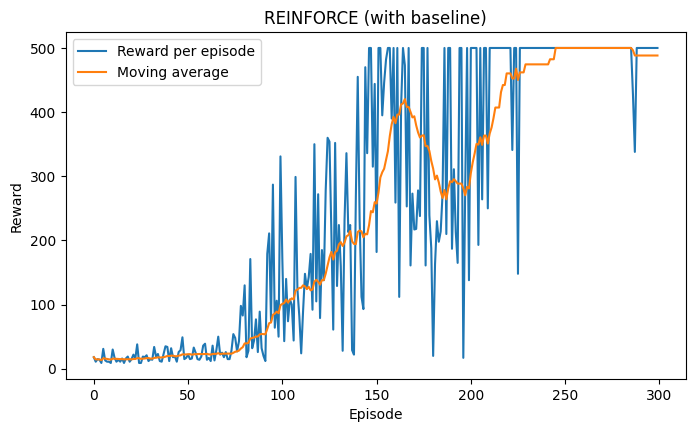

REINFORCE-BL | last-20 mean: 488.25


In [ ]:
re_pg, mv_pg, net_pg = train_reinforce(
    env_name='CartPole-v1', episodes=1000, use_baseline=True,
    lr=1e-3, entropy_start=0.02, entropy_end=0.005)
plot_curve(re_pg, mv_pg, title='REINFORCE (with baseline)')
print('REINFORCE-BL | last-20 mean:', np.mean(re_pg[-20:]) if len(re_pg)>=20 else np.mean(re_pg))


[A2C-B] Ep 50/1000 | R:12.0 | Avg(20): 15.2 | Ent:0.0193
[A2C-B] Ep 100/1000 | R:12.0 | Avg(20): 10.3 | Ent:0.0185
[A2C-B] Ep 150/1000 | R:11.0 | Avg(20): 9.9 | Ent:0.0178
[A2C-B] Ep 200/1000 | R:22.0 | Avg(20): 22.6 | Ent:0.0170
[A2C-B] Ep 250/1000 | R:55.0 | Avg(20): 53.3 | Ent:0.0163
[A2C-B] Ep 300/1000 | R:124.0 | Avg(20): 102.0 | Ent:0.0155
[A2C-B] Ep 350/1000 | R:113.0 | Avg(20): 137.3 | Ent:0.0148
[A2C-B] Ep 400/1000 | R:87.0 | Avg(20): 177.5 | Ent:0.0140
[A2C-B] Ep 450/1000 | R:302.0 | Avg(20): 207.8 | Ent:0.0133
[A2C-B] Ep 500/1000 | R:226.0 | Avg(20): 345.2 | Ent:0.0125
[A2C-B] Ep 550/1000 | R:500.0 | Avg(20): 296.4 | Ent:0.0118
[A2C-B] Ep 600/1000 | R:500.0 | Avg(20): 500.0 | Ent:0.0110
[A2C-B] Ep 650/1000 | R:500.0 | Avg(20): 500.0 | Ent:0.0103
[A2C-B] Ep 700/1000 | R:500.0 | Avg(20): 500.0 | Ent:0.0095
[A2C-B] Ep 750/1000 | R:500.0 | Avg(20): 500.0 | Ent:0.0088
[A2C-B] Ep 800/1000 | R:500.0 | Avg(20): 500.0 | Ent:0.0080
[A2C-B] Ep 850/1000 | R:500.0 | Avg(20): 500.0 | Ent:

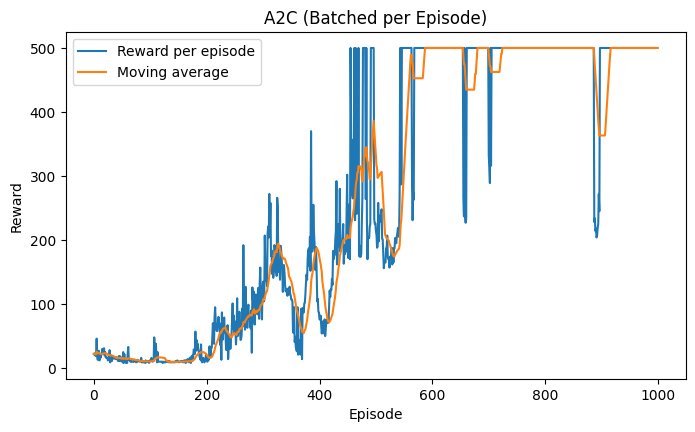

A2C-B | last-20 mean: 500.0


In [ ]:
re_ac, mv_ac, net_ac = train_actor_critic_batched(
    env_name='CartPole-v1', episodes=1000, lr=1e-3,
    value_loss_coeff=0.7, entropy_start=0.02, entropy_end=0.005)
plot_curve(re_ac, mv_ac, title='A2C (Batched per Episode)')
print('A2C-B | last-20 mean:', np.mean(re_ac[-20:]) if len(re_ac)>=20 else np.mean(re_ac))



## Perbandingan Cepat (Opsional)

Jalankan blok di bawah **setelah** Anda menjalankan kedua eksperimen di atas.


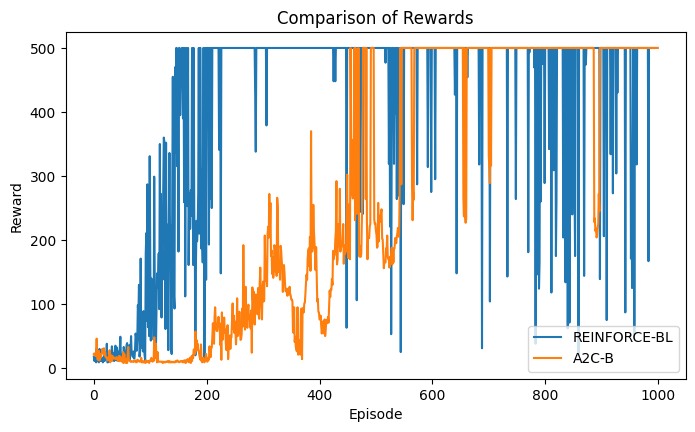

In [ ]:
plt.figure(figsize=(8,4.5))
plt.plot(re_pg, label='REINFORCE-BL')
plt.plot(re_ac, label='A2C-B')
plt.title('Comparison of Rewards')
plt.xlabel('Episode'); plt.ylabel('Reward'); plt.legend(); plt.show()
